In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
import cv2 
import tensorflow as tf
from keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from keras.optimizers import Adamax

In [2]:
X = []
Y = []
Mask_test = []

image_size = 256
labels = ['0', '1', '2', '3']

for i in labels:
    folder_path = os.path.join('/kaggle/input/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset/image', i)
    for j in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, j))
        img = cv2.resize(img, (image_size, image_size))
        X.append(img)
        Y.append(i)

for i in labels:
    folder_path = os.path.join('/kaggle/input/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset/mask', i)
    for j in os.listdir(folder_path):
        mask = cv2.imread(os.path.join(folder_path, j))
        mask = cv2.resize(mask, (image_size, image_size))
        Mask_test.append(mask)

In [3]:
labels_new = ['no_tumor', 'giloma_tumor', 'meningioma_tumor', 'pituitary_tumor']
Y = [int(i) for i in Y]

In [4]:
X = np.array(X)
Y = np.array(Y)
Mask_test = np.array(Mask_test)

In [5]:
print(f'Size of X train dataset: {X.shape}')
print(f'Size of Y train dataset: {Y.shape}')
print(f'Size of Mask test dataset: {Mask_test.shape}')

Size of X train dataset: (4237, 256, 256, 3)
Size of Y train dataset: (4237,)
Size of Mask test dataset: (4239, 256, 256, 3)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=101)

In [7]:
print(f'Size of X train dataset: {X_train.shape}')
print(f'Size of Y train dataset: {y_train.shape}')
print(f'Size of X test dataset: {X_test.shape}')
print(f'Size of Y test dataset: {y_test.shape}')

Size of X train dataset: (3389, 256, 256, 3)
Size of Y train dataset: (3389,)
Size of X test dataset: (848, 256, 256, 3)
Size of Y test dataset: (848,)


### ResNet50

In [8]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):

    F1, F2, F3 = filters

    X_shortcut = X

    layer = layers.Conv2D(F1, kernel_size=1, strides=1, padding='valid', kernel_initializer=initializer(seed=0))(X_shortcut) # F1 bo loc
    layer = layers.BatchNormalization(axis=3)(layer, training=training)
    layer = layers.Activation('relu')(layer)

    layer = layers.Conv2D(F2, kernel_size=f, strides=1, padding='same', kernel_initializer=initializer(seed=0))(layer) # F1 bo loc
    layer = layers.BatchNormalization(axis=3)(layer, training=training)
    layer = layers.Activation('relu')(layer)

    layer = layers.Conv2D(F3, kernel_size=1, strides=1, padding='valid', kernel_initializer=initializer(seed=0))(layer) # F1 bo loc
    layer = layers.BatchNormalization(axis=3)(layer, training=training)
    
    layer = layers.Add()([layer, X_shortcut])
    layer = layers.Activation('relu')(layer)

    return layer

In [9]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    
    F1, F2, F3 = filters
    X_shortcut = X

    layer = layers.Conv2D(F1, kernel_size=1, strides=s, padding='valid', kernel_initializer=initializer(seed=0))(X_shortcut)
    layer = layers.BatchNormalization(axis=3)(layer, training=training)
    layer = layers.Activation('relu')(layer)

    layer = layers.Conv2D(F2, kernel_size=f, strides=1, padding='same', kernel_initializer=initializer(seed=0))(layer)
    layer = layers.BatchNormalization(axis=3)(layer, training=training)
    layer = layers.Activation('relu')(layer)

    layer = layers.Conv2D(F3, kernel_size=1, strides=1, padding='valid', kernel_initializer=initializer(seed=0))(layer)
    layer = layers.BatchNormalization(axis=3)(layer, training=training)
    
    layer_ = layers.Conv2D(F3, kernel_size=1, strides=s, padding='valid', kernel_initializer=initializer(seed=0))(X_shortcut)
    layer_ = layers.BatchNormalization(axis=3)(layer_, training=training)

    layer = layers.Add()([layer, layer_])
    layer = layers.Activation('relu')(layer)

    return layer


In [10]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    inputs = layers.Input(input_shape)

    layer = layers.ZeroPadding2D((3, 3))(inputs)

    layer = layers.Conv2D(64, kernel_size=7, strides=2)(layer)
    layer = layers.BatchNormalization(axis=3)(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPool2D(pool_size=3, strides=2)(layer)

    layer = convolutional_block(layer, f=3, filters=[64, 64, 256], s=1)
    layer = identity_block(layer, f=3, filters=[64, 64, 256])
    layer = identity_block(layer, f=3, filters=[64, 64, 256])

    layer = convolutional_block(layer, f=3, filters=[128, 128, 512], s=2)
    layer = identity_block(layer, f=3, filters=[128, 128, 512])
    layer = identity_block(layer, f=3, filters=[128, 128, 512])
    layer = identity_block(layer, f=3, filters=[128, 128, 512])

    layer = convolutional_block(layer, f=3, filters=[256, 256, 1024], s=2)
    layer = identity_block(layer, f=3, filters=[256, 256, 1024])
    layer = identity_block(layer, f=3, filters=[256, 256, 1024])
    layer = identity_block(layer, f=3, filters=[256, 256, 1024])
    layer = identity_block(layer, f=3, filters=[256, 256, 1024])
    layer = identity_block(layer, f=3, filters=[256, 256, 1024])

    layer = convolutional_block(layer, f=3, filters=[512, 512, 2048], s=2)
    layer = identity_block(layer, f=3, filters=[512, 512, 2048])
    layer = identity_block(layer, f=3, filters=[512, 512, 2048])

    layer = layers.AveragePooling2D(pool_size=2)(layer)
    layer = layers.Flatten()(layer)
    outputs = layers.Dense(classes, activation='softmax')(layer)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [11]:
model = ResNet50(input_shape = (256, 256, 3), classes = 4)

In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      9,472 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 63, 63,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 63, 63,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 63, 63,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 63, 63,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 63, 63,    │     16,640 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 63, 63,    │     16,640 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 63, 63,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 63, 63,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 63, 63,    │          0 │ batch_normalizat

 Total params: 23,718,788 (90.48 MB)

 Trainable params: 23,665,668 (90.28 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [13]:
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [14]:
adamax = Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=adamax, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [15]:
X_train = X_train / 255.
X_test = X_test / 255.

print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))

X_train shape: (3389, 256, 256, 3)
Y_train shape: (3389, 4)


In [16]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50


I0000 00:00:1728369689.019762    3051 service.cc:145] XLA service 0x798f801a4970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728369689.019811    3051 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728369711.554189    3051 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/85 ━━━━━━━━━━━━━━━━━━━━ 94s 510ms/step - accuracy: 0.4227 - loss: 4.8605 - val_accuracy: 0.3673 - val_loss: 1.4018
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 196ms/step - accuracy: 0.6523 - loss: 3.1042 - val_accuracy: 0.4189 - val_loss: 1.4722
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 196ms/step - accuracy: 0.7467 - loss: 0.7538 - val_accuracy: 0.4277 - val_loss: 1.5221
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 196ms/step - accuracy: 0.7963 - loss: 0.5534 - val_accuracy: 0.5044 - val_loss: 1.1063
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 197ms/step - accuracy: 0.8320 - loss: 0.4294 - val_accuracy: 0.6563 - val_loss: 0.8406
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 196ms/step - accuracy: 0.8544 - loss: 0.4945 - val_accuracy: 0.6829 - val_loss: 0.7111
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 196ms/step - accuracy: 0.8733 - loss: 0.3705 - val_accuracy: 0.7448 - val_loss: 0.5849
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 196ms/step - accuracy: 0.8923 - loss: 0.2952 - val_accuracy: 0.724

In [17]:
model.evaluate(X_test, y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.9393 - loss: 0.3226


[0.3686408996582031, 0.9363207817077637]

In [18]:
model.save("model_resnet50.h5")

In [19]:
y_pred = model.predict(X_test).argmax(axis=1)
y_test = y_test.argmax(axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step


In [20]:
pd.DataFrame(y_test).value_counts()

0
0    323
3    206
2    189
1    130
Name: count, dtype: int64

In [21]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       323
           1       0.92      0.91      0.91       130
           2       0.91      0.83      0.87       189
           3       0.97      0.98      0.97       206

    accuracy                           0.94       848
   macro avg       0.93      0.92      0.93       848
weighted avg       0.94      0.94      0.94       848



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted label: pituitary_tumor 
Actual label: pituitary_tumor 
Confidence: 100.00%



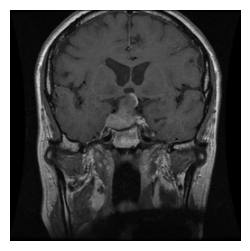

In [22]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]  
predictions = model.predict(random_img.reshape(1, 256, 256, 3))

predicted_class = np.argmax(predictions)
predicted_label = labels_new[predicted_class]
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]
actual_label = labels_new[actual_index]  


print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')  
plt.show()